## Notebook for inferrering inference in a TAP brain

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import sys
sys.path.append('../code')
from plotutils import *

In [2]:
"""
Load the tap brain model
"""
#brain_name = 'Ns_25_noiseseed_2041'
#brain_name = 'Ns_25_noiseseed_6899'
#brain_name = 'Ns_25_noiseseed_5539'
brain_name = 'Ns_25_noiseseed_4021'
#brain_name = 'Ns_5_noiseseed_7044'

use_cuda = False
tapbrain, theta, params = loadbrain('../data/brains/' + brain_name, use_cuda)

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)
 
# process and observation noise covariance matrices and update it in params
q_process, q_obs = 1e-5, 2e-2
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)  
params['Q_process'] = Q_process
params['Q_obs'] = Q_obs

# Set noise seed
noise_seed = np.random.randint(10000)
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

# model_type -- 1: Ux + b, 0: Ux
model_type = 1 if np.any(U<0) else 0
baseline = params['baseline'] if model_type else 0

noise_seed = 4883


In [3]:
"""
Generate measurements using high gain inputs.
These measurements will be used to obtain an initial estimate of the embedding matrix.
"""

B, T = 2000, 50 
T_low, T_high = 2, 5
yG_low, yG_high = 50, 50
T_clip = 20
r_ICA = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)[2]

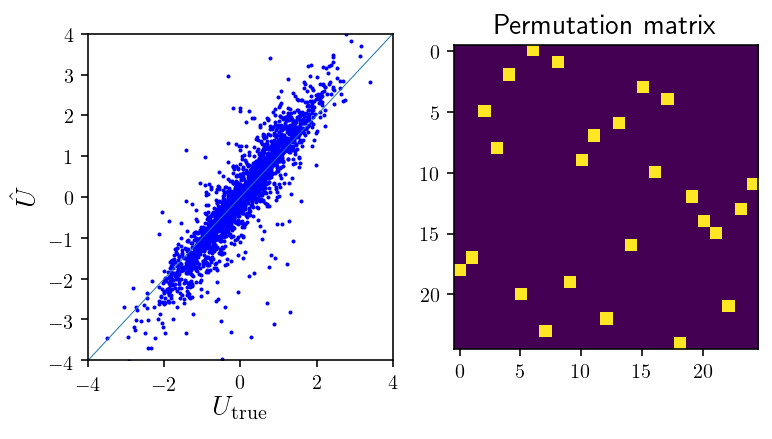

In [5]:
"""
Use ICA to get initial estimate of the embedding
"""
b_init = np.mean(r_ICA) if model_type else 0
U_init = UhatICA(np.reshape(r_ICA.transpose(1,2,0)-b_init,[Nr,T*B],order='F').T, Ns)[0]
#del r_ICA

PermMat_init = EstimatePermutation_ICA(U,U_init) # Estimate the permutation matrix P

"""
Generate random initial estimates of the parameters 
"""
#G_init    = np.zeros([18])
G_init    = 0.01*np.random.randn(18)
G_init[0], G_init[8], G_init[9], G_init[17] = 0, 0, 0, 0

J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values
if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]


# Plot estimate of embedding and permutation matrix
umax = np.ceil(np.max(U))
umin = np.floor(np.min(U))

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_init,PermMat_init).flatten(),'b.',markersize=2)
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set_xlabel(xlabel=r'$U_{\mathrm{true}}$', fontsize=14)
ax[0].set_ylabel(ylabel=r'$\hat{U}$', fontsize=14)
ax[1].imshow(PermMat_init)
ax[1].set_title('Permutation matrix', fontsize=14)
plt.show()

In [6]:
"""
Generate measurements for the particle EM algorithm
"""
B, T = 20000, 25
B_test = 100
yG_low, yG_high = 2, 25

y, x, r_brain = generate_TAPbrain_dynamics(tapbrain,theta, params, B+B_test, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)

mean SNR = 55.0


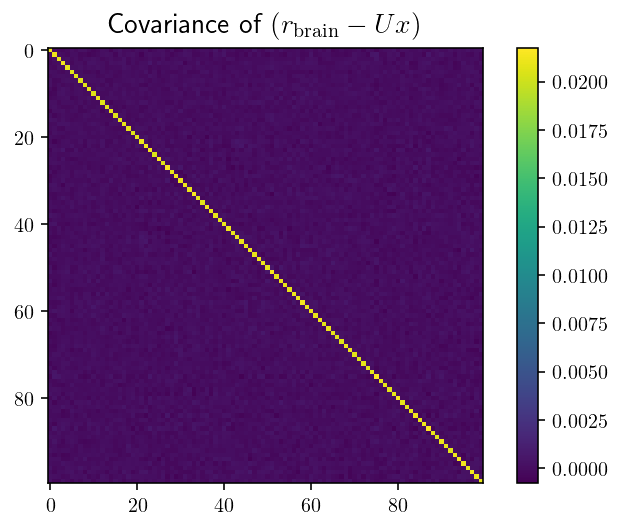

In [7]:
"""
SNR checks
"""
SNR, C_sig, C_err = computeSNR(r_brain-baseline, x, U)
print('mean SNR = %.1f' %(SNR))

plt.imshow(C_err)
plt.title(r'Covariance of $(r_{\mathrm{brain}} - Ux)$',fontsize=14)
plt.colorbar()
plt.show()

In [8]:
"""
Inspect and update update Q_obs. Later insert heuristic to estimate Q_obs
"""
print('mean variance of measurement noise = %.3f' %(np.mean(np.diag(C_err))))
# Q_obs = np.mean(np.diag(C_err))*np.eye(Nr)
Q_obs = np.diag(np.diag(C_err))


mean variance of measurement noise = 0.021


In [9]:
"""
Convert data to torch tensors
"""
device, dtype = "cpu", torch.float64

Q_process_ = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs_     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process_ = Q_process_.inverse()
P_obs_     = Q_obs_.inverse()

r_brain_   = torch.tensor(r_brain,device=device,dtype=dtype)
y_         = torch.tensor(y,device=device,dtype=dtype)


G_      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J_      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U_      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V_      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat_  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat_  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat_  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec_ = torch.tensor(JMatToVec(J_init),device=device,dtype=dtype,requires_grad=True)
J_hat_ = JVecToMat_torch(J_hat_vec_,Ns)
b_hat_ = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

In [10]:
"""
Run PF with true values of parameters
""" 
Np = 100 # No. of particles to use

# B_PLOT = 100
# B_plot = B_PLOT if B>B_PLOT else B

with torch.no_grad():
    #LL_tp_, x_tp_, _, _ = particlefilter(G_, J_, U_, V_, lam.item(), r_brain_[0:B_plot]-baseline, y_[0:B_plot], P_process_, P_obs_, Np)
    LL_tp_, x_tp_, _, _ = particlefilter(G_, J_, U_, V_, lam.item(), r_brain_[B:]-baseline, y_[B:], P_process_, P_obs_, Np)

r_tp_ = torch.matmul(U_,x_tp_) + baseline
    
"""
Run PF with initial values of parameters
"""
t_st = time.time()
with torch.no_grad():
    #LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[0:B_plot]-b_init, y_[0:B_plot], P_process_, P_obs_, Np)
    LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[B:]-b_init, y_[B:], P_process_, P_obs_, Np)
t_en = time.time()

print('time elapsed = %.2f s' %(t_en - t_st))

print('log likelihood with true parameters = %.1f' %(LL_tp_.mean().data.numpy()))
print('log likelihood with initial parameters = %.1f' %(LL_hat_.mean().data.numpy()))

# make a copy of the latent dynamics and fits to neural activity obtained using initial estimates of the parameters
x_init_ = x_hat_*1.0
r_init_ = torch.matmul(U_hat_,x_hat_) + b_init

time elapsed = 6.37 s
log likelihood with true parameters = -1172.5
log likelihood with initial parameters = -173133.0


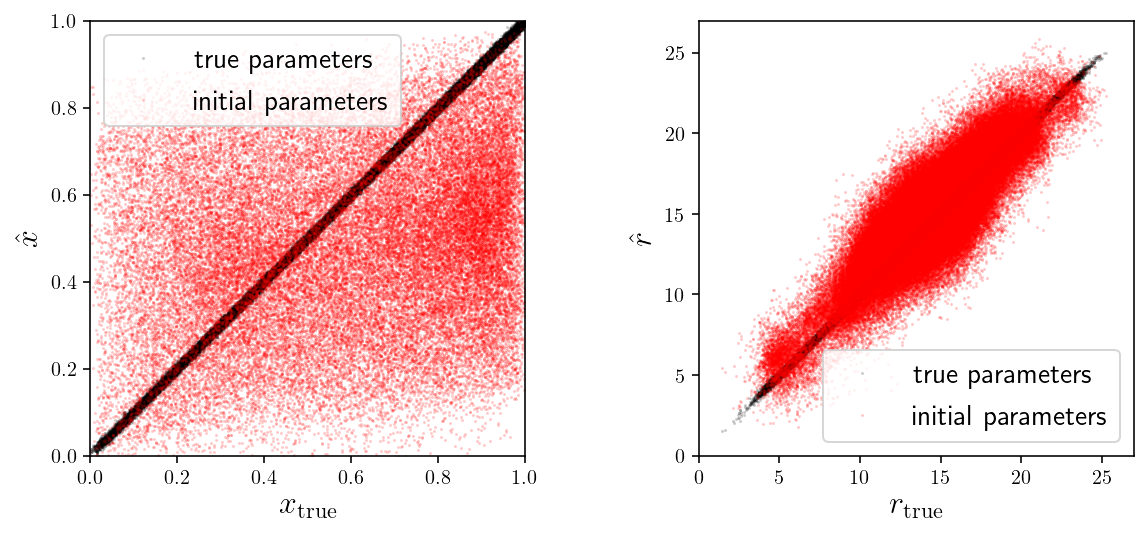

In [11]:
"""
Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
"""

T_st = 5 # discard the first T_st samples from each batch for comparisons

alpha = 0.2
fig, ax = plt.subplots(1,2,figsize=(10,4))
#ax[0].plot(x[0:B_plot,:,T_st:].flatten(), x_tp_[...,T_st:].flatten(),'k.',markersize=1,alpha=alpha)
ax[0].plot(x[B:,:,T_st:].flatten(), x_tp_[...,T_st:].flatten(),'k.',markersize=1,alpha=alpha)
P_temp = torch.tensor(PermMat_init.T,device=device,dtype=dtype,requires_grad=False)
#ax[0].plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_init_[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
ax[0].plot(x[B:,:,T_st:].flatten(), torch.matmul(P_temp, x_init_[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
ax[0].set_xlabel(r'$x_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{x}$',fontsize=16)
ax[0].legend(['true parameters', 'initial parameters'],fontsize=14)
ax[0].axis('square')
ax[0].axis([0,1,0,1])

rmax = np.round(r_brain.max().item())
rmin = np.round(r_brain.min().item())

# ax[1].plot(r_brain_[0:B_plot,:,T_st:].data.numpy().flatten(),r_tp_[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=alpha)
# ax[1].plot(r_brain_[0:B_plot,:,T_st:].data.numpy().flatten(),r_init_[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
ax[1].plot(r_brain_[B:,:,T_st:].data.numpy().flatten(),r_tp_[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=alpha)
ax[1].plot(r_brain_[B:,:,T_st:].data.numpy().flatten(),r_init_[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=alpha)
ax[1].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{r}$',fontsize=16)
ax[1].legend(['true parameters', 'initial parameters'],fontsize=14)
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])


plt.show()

## run particle EM

In [12]:
lrate       = 4e-3
NIterations = 25000

if model_type:
    opt_params = [G_hat_,J_hat_vec_,U_hat_, V_hat_, b_hat_]
else:
    opt_params = [G_hat_,J_hat_vec_,U_hat_, V_hat_]

optimizer  = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))

batch_size = 3

LLVec      = [] #record the log likelihoods

t_st = time.time()

for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/16, betas=(0.9, 0.999))
        
        
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    with torch.no_grad():
        LL_b_, x_b_, P_b_, W_b_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx]-b_hat_, y_[idx], P_process_, P_obs_, Np)

        
    # E-step
    C_ = Qfunction(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx,:,T_st:]-b_hat_, y_[idx,:,T_st:], P_b_[...,T_st:], W_b_, P_process_, P_obs_)
    
    # M-step
    C_.backward() 
    G_hat_.grad[0], G_hat_.grad[9]  = 0, 0 # set gradient of G0 and G9 to zero
    #G_hat_.grad[8], G_hat_.grad[17] = 0, 0 # set gradient of G8 and G17 to zero
    optimizer.step()
    
    # record the log likelihood
    if (iteration+1)%100 == 0:
        with torch.no_grad():
            #LL_rec_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[0:B_plot]-b_hat_, y_[0:B_plot], P_process_, P_obs_, Np)[0]
            LL_rec_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[B:]-b_hat_, y_[B:], P_process_, P_obs_, Np)[0]
            LLVec.append(LL_rec_.mean())
    
    if (iteration+1)%1000 == 0:
        print('[%d] log likelihood: %.1f' %(iteration + 1, LL_rec_.mean()))
        
        
t_en = time.time()

print('Finished training')
print('Time elapsed = %.1f mins'%((t_en - t_st)/60))

[1000] log likelihood: -3160.9
[2000] log likelihood: -2553.9
[3000] log likelihood: -2250.5
[4000] log likelihood: -1936.8
[5000] log likelihood: -1725.0
[6000] log likelihood: -1610.3
[7000] log likelihood: -1497.1
[8000] log likelihood: -1394.4
[9000] log likelihood: -1370.3
[10000] log likelihood: -1354.8
[11000] log likelihood: -1396.6
[12000] log likelihood: -1355.8
[13000] log likelihood: -1223.1
[14000] log likelihood: -1220.1
[15000] log likelihood: -1224.7
[16000] log likelihood: -1228.7
[17000] log likelihood: -1218.0
[18000] log likelihood: -1217.4
[19000] log likelihood: -1190.1
[20000] log likelihood: -1189.5
[21000] log likelihood: -1188.8
[22000] log likelihood: -1187.6
[23000] log likelihood: -1185.8
[24000] log likelihood: -1187.4
[25000] log likelihood: -1186.4
Finished training
Time elapsed = 175.8 mins


In [13]:
"""
Run the PF on the first B_plot batches
"""

J_hat_ = JVecToMat_torch(J_hat_vec_,Ns)
with torch.no_grad():
    #LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[0:B_plot]-b_hat_, y_[0:B_plot], P_process_, P_obs_, Np)
    LL_hat_, x_hat_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_brain_[B:]-b_hat_, y_[B:], P_process_, P_obs_, Np)

print('log likelihood with inferred parameters = %.1f' %(LL_hat_.mean().data.numpy()))

# fit to neural activity
r_hat_ = torch.matmul(U_hat_, x_hat_) + b_hat_

log likelihood with inferred parameters = -1187.1


## Visualizing results

In [14]:
G_hat = G_hat_.detach().cpu().data.numpy()
J_hat = J_hat_.detach().cpu().data.numpy()
U_hat = U_hat_.detach().cpu().data.numpy()
V_hat = V_hat_.detach().cpu().data.numpy()
b_hat = b_hat_.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat  = EstimatePermutation_ICA(U, U_hat)
PermMat_ = torch.tensor(PermMat,device=device,dtype=dtype,requires_grad=False)
PermMat_init_ = torch.tensor(PermMat_init,device=device,dtype=dtype,requires_grad=False)


# Permute all the inferred variables and convert to numpy arrays
x_init = torch.matmul(PermMat_init_.t(), x_init_).data.numpy()
x_hat  = torch.matmul(PermMat_.t(), x_hat_).data.numpy() 

r_init = r_init_.data.numpy()
r_hat  = r_hat_.data.numpy()

J_hat  = permuteJ(J_hat, PermMat)
J_init = permuteJ(J_init, PermMat_init)

U_hat  = np.dot(U_hat, PermMat)
U_init = np.dot(U_init, PermMat_init)

V_hat  = np.dot(PermMat.T, V_hat)
V_init = np.dot(PermMat_init.T, V_init)

Jmax = max(np.max(J),np.max(J_hat))
Jmin = min(np.min(J),np.min(J_hat))

umax = np.max(U)
umin = np.min(U)

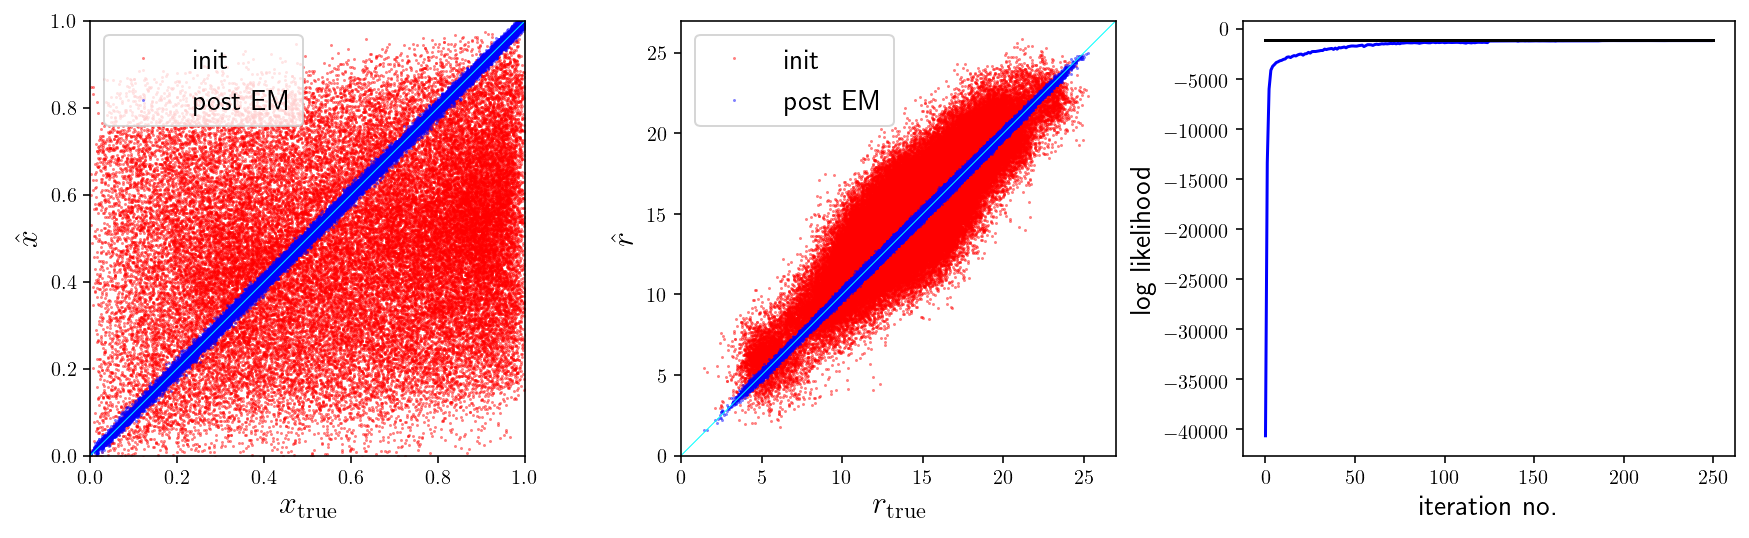

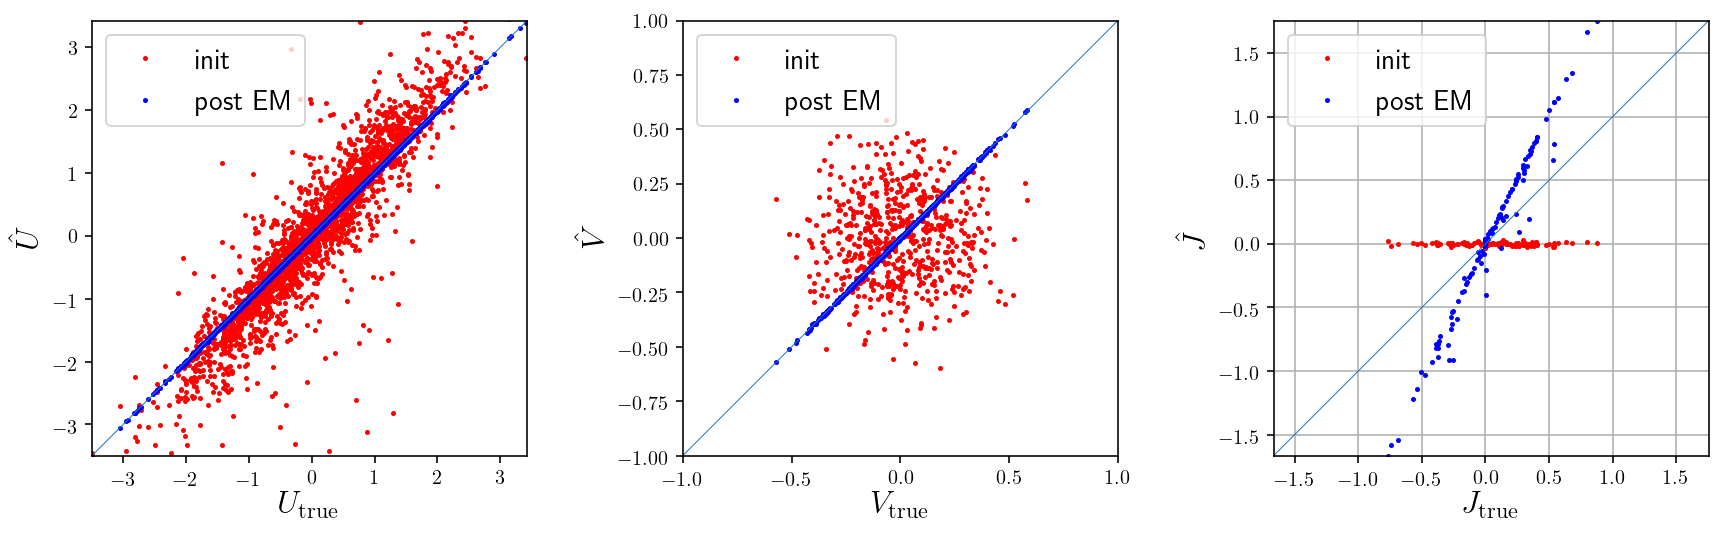

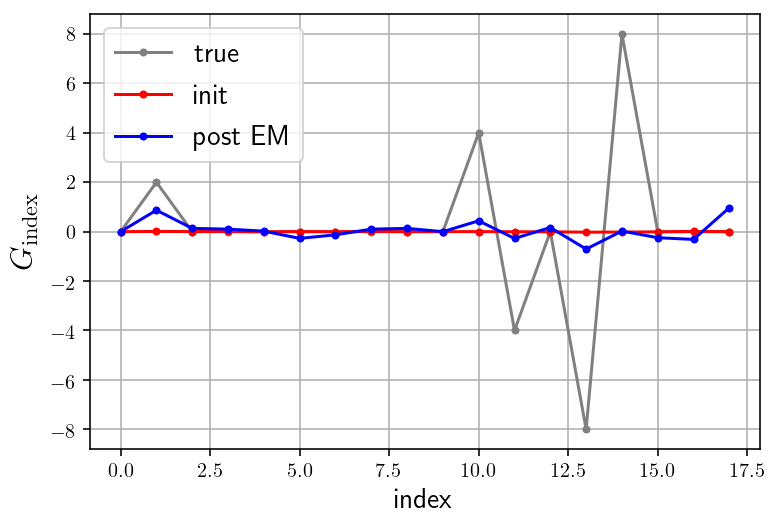

In [15]:
"""
Plotting results
"""
alpha = 0.5 #opacity

# figure 1
fig, ax = plt.subplots(1,3,figsize=(15,4))

# ax[0].plot(x[0:B_plot,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
# ax[0].plot(x[0:B_plot,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
ax[0].plot(x[B:,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
ax[0].plot(x[B:,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
ax[0].plot([0,1],[0,1],linewidth=0.5,color='cyan')
ax[0].set_xlabel(r'$x_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{x}$',fontsize=16)
ax[0].legend(['init', 'post EM'],fontsize=14)
ax[0].axis('square')
ax[0].axis([0,1,0,1])

# ax[1].plot(r_brain[0:B_plot,:,T_st:].flatten(),r_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
# ax[1].plot(r_brain[0:B_plot,:,T_st:].flatten(),r_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
ax[1].plot(r_brain[B:,:,T_st:].flatten(),r_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
ax[1].plot(r_brain[B:,:,T_st:].flatten(),r_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
ax[1].plot([rmin,rmax],[rmin,rmax],linewidth=0.5,color='cyan')
ax[1].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{r}$',fontsize=16)
ax[1].legend(['init', 'post EM'],fontsize=14)
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

ax[2].plot(LLVec,'b')
ax[2].plot([0,len(LLVec)],LL_tp_.mean().item()*np.ones([2]),'k')
ax[2].set_xlabel('iteration no.',fontsize=14)
ax[2].set_ylabel('log likelihood', fontsize=14)
plt.show()


# Figure 2                         
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(U.flatten(),U_init.flatten(),'r.',markersize=3)
ax[0].plot(U.flatten(),U_hat.flatten(),'b.',markersize=3)
ax[0].axis('square')
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set_xlabel(r'$U_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{U}$',fontsize=16)
ax[0].legend(['init', 'post EM'],fontsize=14)

ax[1].plot(V.flatten(),V_init.flatten(),'r.',markersize=3)
ax[1].plot(V.flatten(),V_hat.flatten(),'b.',markersize=3)
ax[1].axis('square')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].axis([-1,1,-1,1])
ax[1].set_xlabel(r'$V_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{V}$',fontsize=16)
ax[1].legend(['init', 'post EM'],fontsize=14)

ax[2].plot(JMatToVec(J),JMatToVec(J_init),'r.',markersize=3)
ax[2].plot(JMatToVec(J),JMatToVec(J_hat),'b.',markersize=3)
ax[2].axis('square')
ax[2].plot([Jmin,Jmax],[Jmin,Jmax],linewidth=0.5)
ax[2].axis([Jmin,Jmax,Jmin,Jmax])
ax[2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[2].set_ylabel(r'$\hat{J}$',fontsize=16)
ax[2].legend(['init', 'post EM'],fontsize=14)
ax[2].grid(True)

#plt.savefig('Parameters.pdf')
plt.show()

# Plot G 
plt.plot(G,'.-',color='gray')
plt.plot(G_init,'r.-')
plt.plot(G_hat,'b.-')
plt.legend(['true','init','post EM'],fontsize=14)
plt.xlabel('index',fontsize=14)
plt.ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
plt.grid(True)
#plt.savefig('G.pdf')
plt.show()

In [16]:
# normalize J and G
J_true_vec = JMatToVec(J)
z = np.polyfit(J_true_vec, JMatToVec(J_hat),1)

# normalize G_hat and J_hat
z[1] = 0
J_hat_normalized = (JMatToVec(J_hat) - z[1])/z[0]

G_hat_normalized = G_hat*1.0
G_hat_normalized[0:9] = z[0]*G_hat[0:9] + 2*z[0]*z[1]*G_hat[9:]
G_hat_normalized[9:] = (z[0]**2)*G_hat[9:]

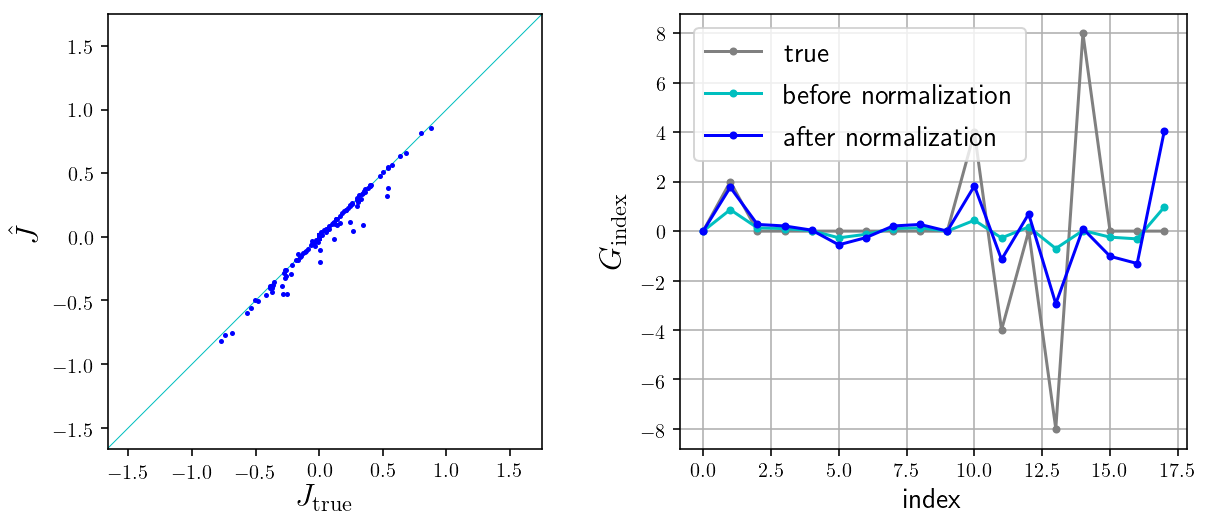

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot([Jmin,Jmax],[Jmin,Jmax],'c',linewidth=0.5)
ax[0].plot(J_true_vec,J_hat_normalized,'b.',markersize=3)
ax[0].axis('square')
ax[0].axis([Jmin,Jmax,Jmin,Jmax])
ax[0].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{J}$',fontsize=16)

ax[1].plot(G,'.-',color='gray')
ax[1].plot(G_hat,'c.-')
ax[1].plot(G_hat_normalized,'b.-')
ax[1].grid(True)
ax[1].set_xlabel('index',fontsize=14)
ax[1].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
ax[1].legend(['true','before normalization','after normalization'],fontsize=14)
#plt.savefig('NormalizedJG.pdf')
plt.show()

In [18]:
"""
Validate on new measurements
"""

B_val = 100
T_clip = 0
y_val = generate_Input(params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

x0 = np.random.rand(Ns,B_val) # initial values

# Run TAP dynamics using true theta
x_val 	= runTAP(x0, y_val, Q_process, Q_obs, theta, params['nltype'])

# Run TAP dynamics using inferred theta
theta_hat = np.concatenate([np.array([lam]), G_hat, JMatToVec(J_hat), U_hat.flatten('F'), V_hat.flatten('F') ])
x_hat_val = runTAP(x0, y_val, Q_process, Q_obs, theta_hat, params['nltype'])

x_val = x_val[...,T_clip:].transpose(1,2,0)
x_hat_val = x_hat_val[...,T_clip:].transpose(1,2,0)
truth = x_val.flatten()
test = x_hat_val.flatten()

RMSE = 0.008


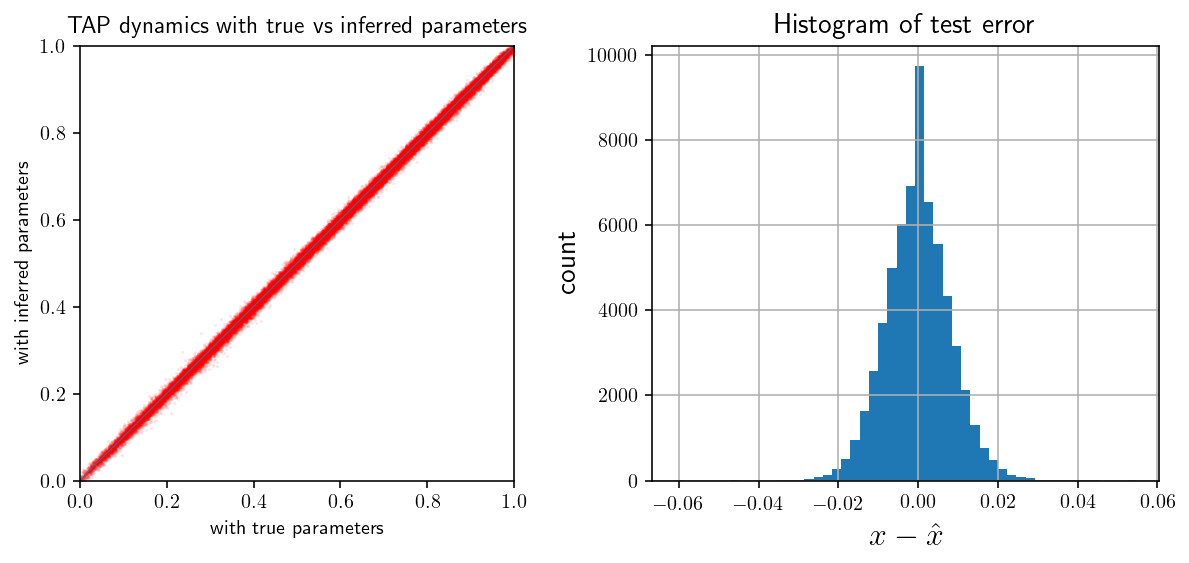

In [19]:
"""
Plot results on test set
"""

print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(truth,test,'r.',markersize=1,alpha=0.1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].hist(truth-test,50)
ax[1].set_xlabel(r'$x - \hat{x}$',fontsize=16)
ax[1].set_ylabel('count', fontsize=14)
ax[1].set_title('Histogram of test error', fontsize=14)
ax[1].grid(True)
#ax[1].axis([-0.1,0.1,0,25000])
#plt.savefig('Xvalidation.pdf')
plt.show()

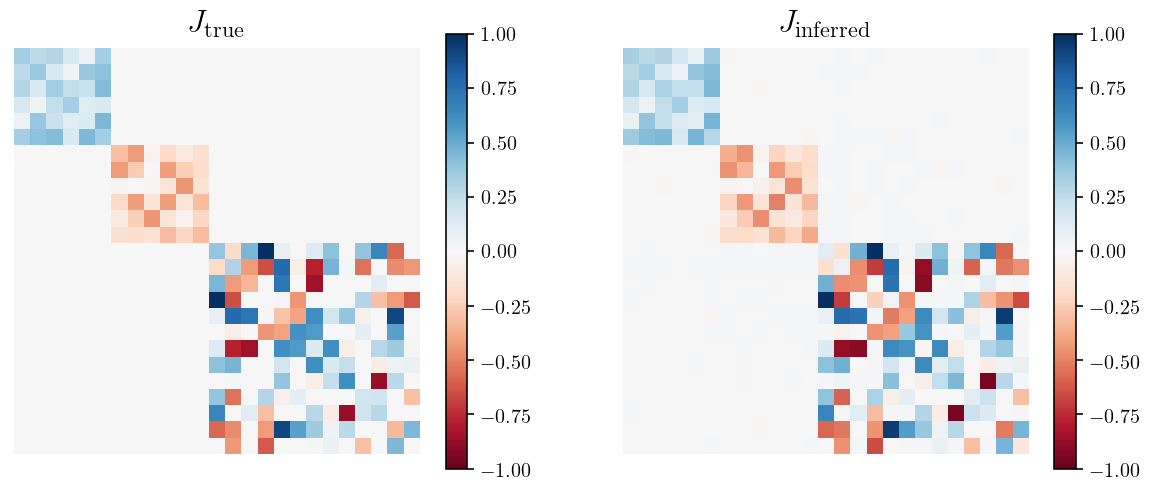

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
pcm = ax[0].imshow(J/np.max(np.abs(J)),vmin=-1,vmax=1,cmap='RdBu')
ax[0].set_title(r'$J_{\mathrm{true}}$',fontsize=16)
ax[0].axis('off')
fig.colorbar(pcm, ax=ax[0])
JMat_normalized = JVecToMat(J_hat_normalized,Ns)
pcm = ax[1].imshow(JMat_normalized/np.max(np.abs(JMat_normalized)),vmin=-1,vmax=1,cmap='RdBu')
ax[1].set_title(r'$J_{\mathrm{inferred}}$',fontsize=16)
ax[1].axis('off')
fig.colorbar(pcm, ax=ax[1])
#plt.savefig('Jestimates.pdf')
plt.show()

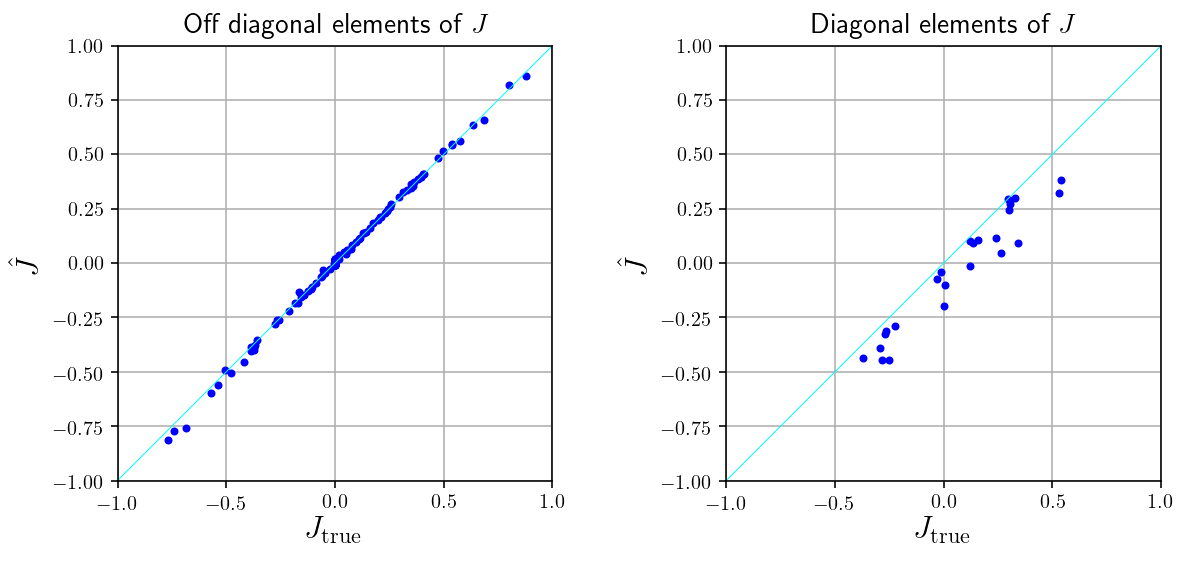

In [21]:
J1 = J - np.diag(np.diag(J))
J_Mat_normalized = JVecToMat(J_hat_normalized, Ns)
J_hat1 = J_Mat_normalized - np.diag(np.diag(J_Mat_normalized))


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(JMatToVec(J1), JMatToVec(J_hat1),'b.')
ax[0].plot([-1,1],[-1,1],linewidth=0.5,color='cyan')
ax[0].axis('square')
ax[0].axis([-1,1,-1,1])
ax[0].grid(True)
ax[0].set_title(r'Off diagonal elements of $J$', fontsize=14)
ax[0].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{J}$',fontsize=16)

ax[1].plot(np.diag(J), np.diag(J_Mat_normalized),'b.')
ax[1].plot([-1,1],[-1,1],linewidth=0.5,color='cyan')
ax[1].axis('square')
ax[1].axis([-1,1,-1,1])
ax[1].grid(True)
ax[1].set_title(r'Diagonal elements of $J$', fontsize=14)
ax[1].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{J}$',fontsize=16)

plt.show()

In [22]:
"""
save all the required variables
"""

params['Q_obs'] = Q_obs

# initial values of parameters
init_parameters = {'G_init':G_init, 'J_init':J_init, 'U_init':U_init, 'V_init':V_init, 'b_init':b_init}

# inferred parameters
inferred_parameters = {'G_hat':G_hat, 'J_hat':J_hat, 'U_hat':U_hat, 'V_hat':V_hat, 'b_hat':b_hat }

fname = 'inference_' + brain_name + '_noise_seed_' + str(noise_seed) + '.pkl'
print(fname)

with open(fname, 'wb') as f:  
    pickle.dump([theta, params, init_parameters, inferred_parameters], f)
f.close()

inference_Ns_25_noiseseed_4021_noise_seed_4883.pkl


## Generate final figures

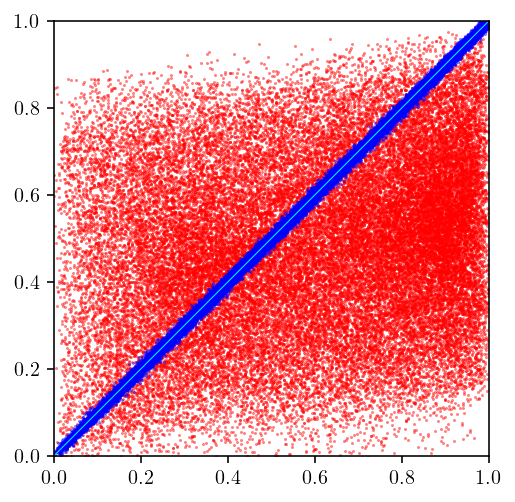

In [23]:
plt.plot(x[B:,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
plt.plot(x[B:,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
plt.plot([0,1],[0,1],linewidth=0.5,color='cyan')
plt.axis('square')
plt.axis([0,1,0,1])
plt.savefig('Inferred_X.png',dpi=300)

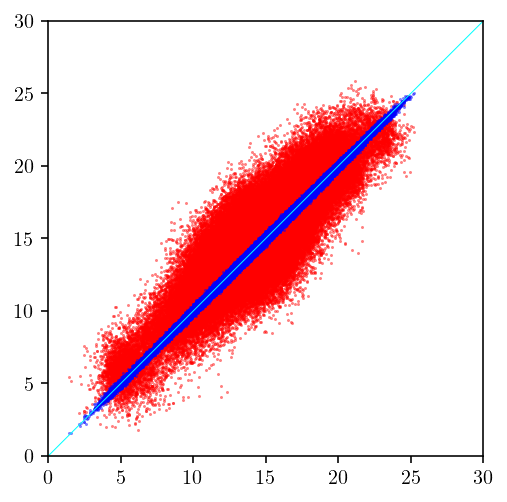

In [24]:
plt.plot(r_brain[B:,:,T_st:].flatten(),r_init[...,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
plt.plot(r_brain[B:,:,T_st:].flatten(),r_hat[...,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
plt.plot([0,30],[0,30],linewidth=0.5,color='cyan')
plt.axis('square')
plt.axis([0,30,0,30])
plt.savefig('Inferred_R.png',dpi=300)

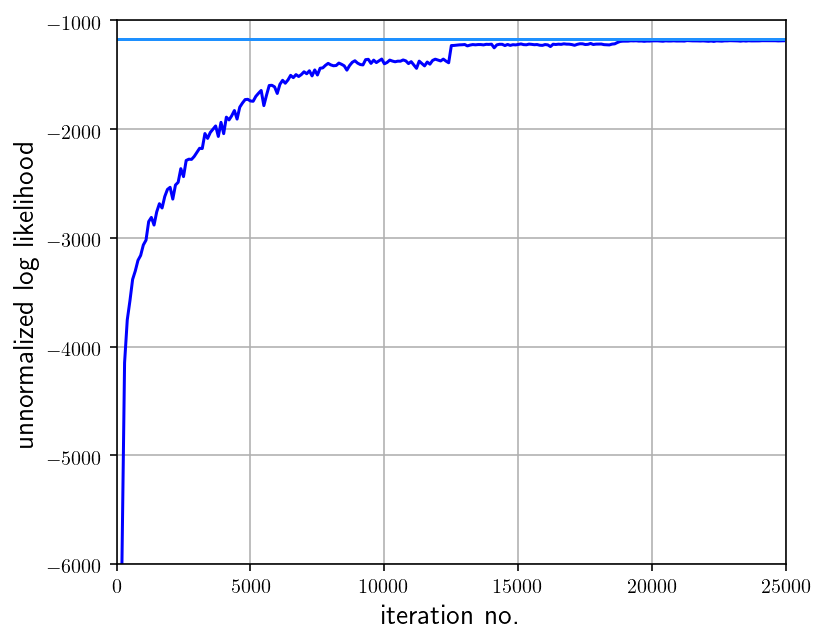

In [25]:
plt.figure(figsize=(6,5))
plt.plot(np.arange(0,len(LLVec))*100,LLVec,'b')
plt.plot([0,100*len(LLVec)],LL_tp_.mean().item()*np.ones([2]),'dodgerblue')
plt.xlabel('iteration no.',fontsize=14)
plt.ylabel('unnormalized log likelihood', fontsize=14)
plt.axis([0, 25000, -6000, -1000])
plt.grid(True)
plt.savefig('Loglikelihood.pdf')
plt.show()

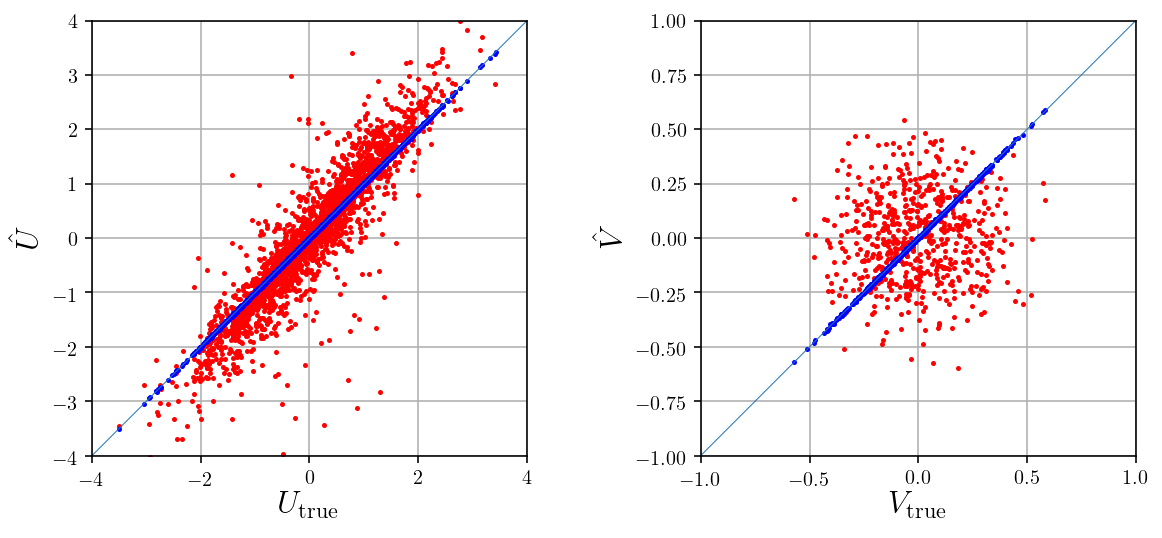

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(U.flatten(),U_init.flatten(),'r.',markersize=3)
ax[0].plot(U.flatten(),U_hat.flatten(),'b.',markersize=3)
ax[0].axis('square')
ax[0].plot([-4,4],[-4,4],Linewidth=0.5)
ax[0].axis([-4,4,-4,4])
ax[0].set_xlabel(r'$U_{\mathrm{true}}$',fontsize=16)
ax[0].set_ylabel(r'$\hat{U}$',fontsize=16)
ax[0].grid(True)
#ax[0].legend(['init', 'post EM'],fontsize=14)

ax[1].plot(V.flatten(),V_init.flatten(),'r.',markersize=3)
ax[1].plot(V.flatten(),V_hat.flatten(),'b.',markersize=3)
ax[1].axis('square')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].axis([-1,1,-1,1])
ax[1].set_xlabel(r'$V_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{V}$',fontsize=16)
ax[1].grid(True)
#ax[1].legend(['init', 'post EM'],fontsize=14)
plt.savefig('Inferred_U_V.pdf')


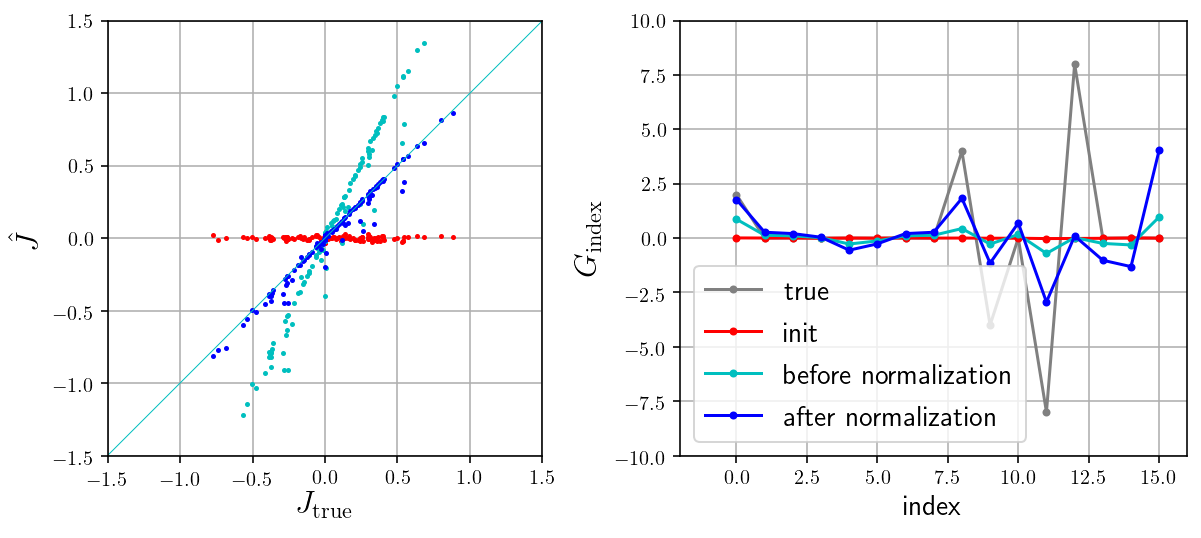

In [28]:
def reshapeG(GVec):
    GVec = GVec.tolist()
    #GVec.pop(17)
    GVec.pop(9)
    #GVec.pop(8)
    GVec.pop(0)
    return np.array(GVec)


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(J_true_vec,JMatToVec(J_init),'r.',markersize=3)
ax[0].plot(J_true_vec,JMatToVec(J_hat),'c.',markersize=3)
ax[0].plot(J_true_vec,J_hat_normalized,'b.',markersize=3)
ax[0].axis('square')
ax[0].axis([-1.5,1.5,-1.5,1.5])
ax[0].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
#ax[0].legend(['true','before normalization','after normalization'],fontsize=14)
ax[0].plot([-1.5,1.5],[-1.5,1.5],'c',linewidth=0.5)
ax[0].grid(True)
ax[0].set_ylabel(r'$\hat{J}$',fontsize=16)

ax[1].plot(reshapeG(G),'.-',color='gray')
ax[1].plot(reshapeG(G_init),'r.-')
ax[1].plot(reshapeG(G_hat),'c.-')
ax[1].plot(reshapeG(G_hat_normalized),'b.-')
ax[1].grid(True)
ax[1].set_xlabel('index',fontsize=14)
ax[1].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
ax[1].legend(['true','init','before normalization','after normalization'],fontsize=14)
ax[1].axis([-2,16,-10,10])
plt.savefig('Estimated_J_G.pdf')
plt.show()

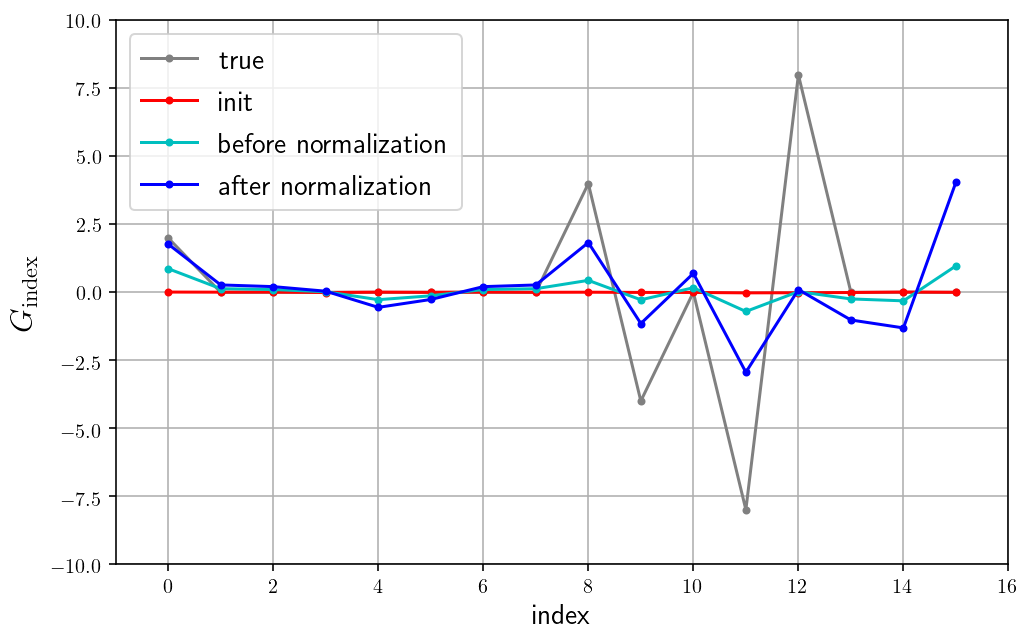

In [29]:
plt.figure(figsize=(8,5))
plt.plot(reshapeG(G),'.-',color='gray')
plt.plot(reshapeG(G_init),'r.-')
plt.plot(reshapeG(G_hat),'c.-')
plt.plot(reshapeG(G_hat_normalized),'b.-')
plt.grid(True)
plt.xlabel('index',fontsize=14)
plt.ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
plt.legend(['true','init','before normalization','after normalization'],fontsize=14)
plt.axis([-1,16,-10,10])
plt.savefig('Estimated_G.pdf')

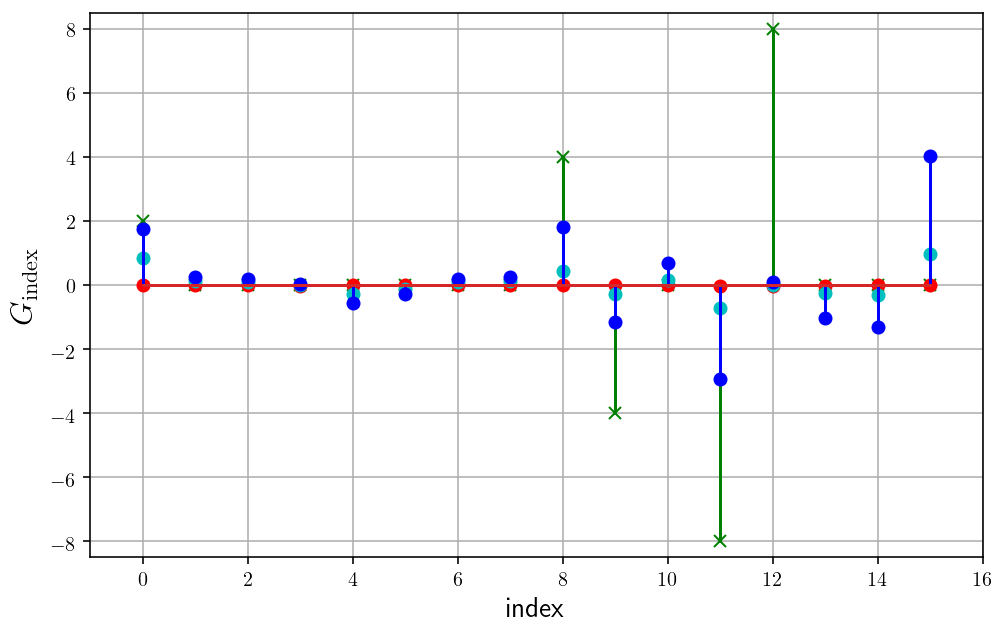

In [30]:
plt.figure(figsize=(8,5))
plt.stem(reshapeG(G),linefmt='g',markerfmt='gx')
plt.stem(reshapeG(G_init), linefmt='r', markerfmt='ro', basefmt=None)
plt.stem(reshapeG(G_hat), linefmt='c', markerfmt='co', basefmt=None)
plt.stem(reshapeG(G_hat_normalized), linefmt='b', markerfmt='bo', basefmt=None)
plt.xlabel('index',fontsize=14)
plt.ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
plt.grid(True)
plt.axis([-1,16,-8.5,8.5])
plt.savefig('Estimated_G_stemplot.pdf')

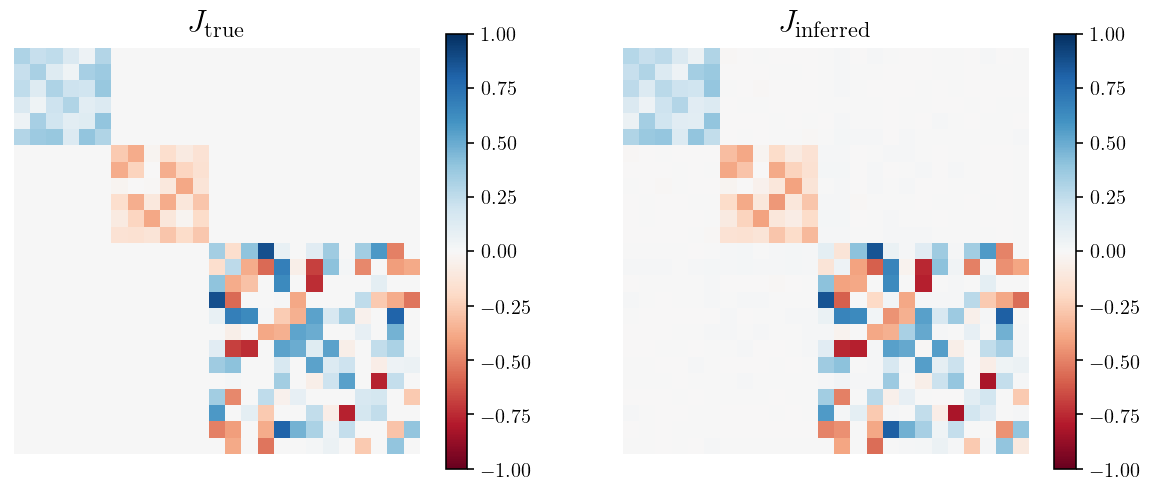

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
pcm = ax[0].imshow(J,vmin=-1,vmax=1,cmap='RdBu')
ax[0].set_title(r'$J_{\mathrm{true}}$',fontsize=16)
ax[0].axis('off')
fig.colorbar(pcm, ax=ax[0])
JMat_normalized = JVecToMat(J_hat_normalized,Ns)
pcm = ax[1].imshow(JMat_normalized,vmin=-1,vmax=1,cmap='RdBu')
ax[1].set_title(r'$J_{\mathrm{inferred}}$',fontsize=16)
ax[1].axis('off')
fig.colorbar(pcm, ax=ax[1])
plt.savefig('Inferred_J_Adj.pdf')
plt.show()

RMSE = 0.008


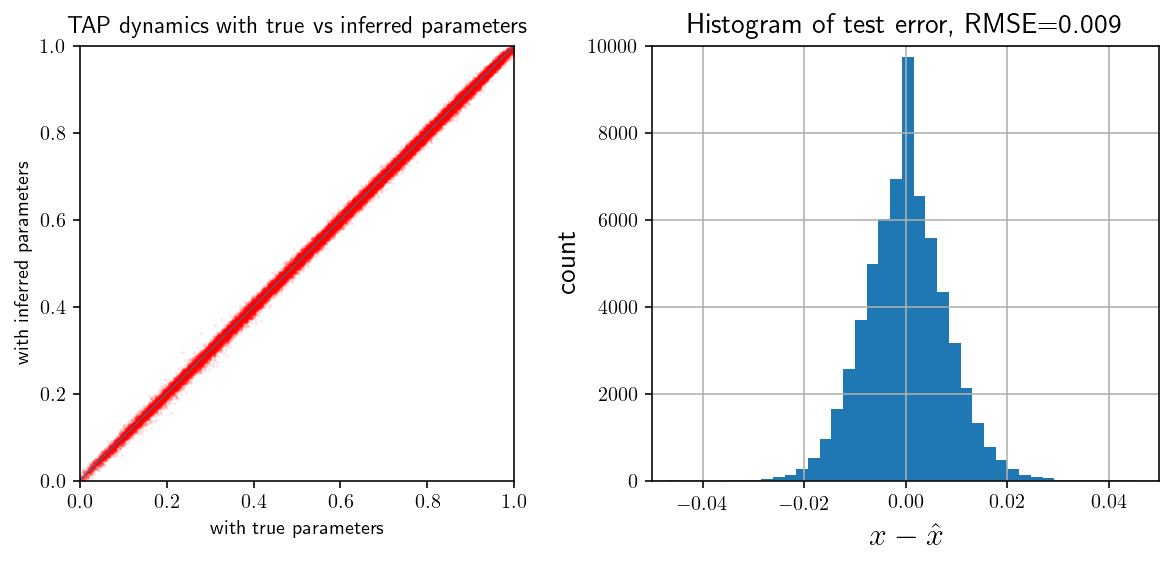

In [32]:
"""
Plot results on test set
"""

print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(truth,test,'r.',markersize=1,alpha=0.1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].hist(truth-test,50)
ax[1].set_xlabel(r'$x - \hat{x}$',fontsize=16)
ax[1].set_ylabel('count', fontsize=14)
ax[1].set_title('Histogram of test error, RMSE=0.009', fontsize=14)
ax[1].grid(True)
ax[1].axis([-0.05,0.05,0,10000])
plt.savefig('X_testdata.pdf')
plt.show()